# First part of The Coursera Capstone

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

Using beautiful soup we will find the table in the web page, and extract the usefull information

In [2]:
#scrape the wikipedia page
response=requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
soup=BeautifulSoup(response.text,'html.parser')
#find the table
table=soup.find_all(name='tr')
split_table=[]
#iterate through the entries in the table
for i in table:
    #split the row of the table by new line
    row=i.text.strip('\n').split('\n')
    #check if the row has three entries(other tables have more or less than three) and if the borough is assigned
    if len(row)==3 and 'Not assigned' != row[1]:
        #if the neighborhood is unassigned, assign it to the borough name
        if row[2]=='Not assigned':
            row[2]=row[1]
        split_table.append(row)

In [3]:
#assign the results to a dataframe with the first entry of the list being the columns
neighborhood_df=pd.DataFrame(split_table[1:],columns=split_table[0])
neighborhood_df.head()

,Postcode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M5A,Downtown Toronto,Regent Park
4,M6A,North York,Lawrence Heights


In [4]:
import geocoder

ModuleNotFoundError: No module named 'geocoder'

In [5]:
# initialize your variable to None
lat_lng_coords = None

# loop until you get the coordinates
postal_code='M3A'
c=0
while(lat_lng_coords is None) and c<500:
    g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
    lat_lng_coords = g.latlng
    c+=1
    print(c,end='\r')

#latitude = lat_lng_coords[0]
#longitude = lat_lng_coords[1]

NameError: name 'geocoder' is not defined

I ran through five hundred iteration and couldn't get the lat and long for the first postal code (and that is for just one postal code, let alone all of the postal codes).  At this rate, I will hit the 2500 limit well before getting all the codes, so I will use the csv file provided to get the lat and long values.

In [6]:
code_df=pd.read_csv('http://cocl.us/Geospatial_data')
code_df.columns=['Postcode','Lat','Long']
code_df.head()

,Postcode,Lat,Long
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


merge the two data sets

In [7]:
full_df=pd.merge(neighborhood_df,code_df,on='Postcode')

In [8]:
full_df.head()

,Postcode,Borough,Neighbourhood,Lat,Long
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,Harbourfront,43.654260,-79.360636
3,M5A,Downtown Toronto,Regent Park,43.654260,-79.360636
4,M6A,North York,Lawrence Heights,43.718518,-79.464763


In [9]:
from sklearn.cluster import KMeans

To start we will cluster the neighborhoods into five groups by location

In [10]:
clusters=KMeans(n_clusters=5, random_state=0).fit(full_df[['Lat','Long']])

In [11]:
from matplotlib import pyplot as plt

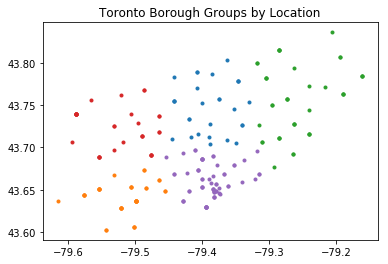

In [12]:
for i in range(5):
    points=full_df[['Lat','Long']][clusters.labels_==i]
    plt.plot(points['Long'],points['Lat'],'.')
plt.title('Toronto Borough Groups by Location')
plt.show()

Next we will group by Borough the boroughs

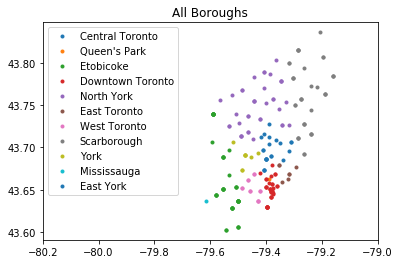

In [13]:
distinct_list=list(set(full_df['Borough']))
for i in range(len(distinct_list)):
    points=full_df[['Lat','Long']][full_df['Borough']==distinct_list[i]]
    plt.plot(points['Long'],points['Lat'],'.',label=distinct_list[i])
plt.xlim([-80.2,-79])
plt.legend()
plt.title('All Boroughs')
plt.show()

We can see in the above plot that there is a little more mixing of groups when we plot by Borough

Now we will just use the Boroughs that have Toronto in the Name

In [14]:
tor_bor=[]
for i in distinct_list:
    if 'Toronto' in i:
        tor_bor.append(i)
tor_bor

['Central Toronto', 'Downtown Toronto', 'East Toronto', 'West Toronto']

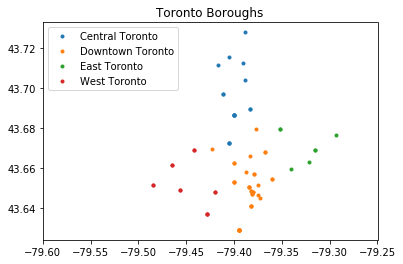

In [15]:
for i in range(len(tor_bor)):
    points=full_df[['Lat','Long']][full_df['Borough']==tor_bor[i]]
    plt.plot(points['Long'],points['Lat'],'.',label=tor_bor[i])
plt.xlim([-79.6,-79.25])
plt.legend()
plt.title('Toronto Boroughs')
plt.show()

We now have four groups that are farely well separated

In [16]:
full_df.to_csv('lat_lon_ata.csv')